In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
output_path = '/home/FRACTAL/shaheen.perveen/stage3/model_outputs/'

In [3]:
import os
os.chdir('/home/FRACTAL/shaheen.perveen/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

In [5]:
#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
#using  device 0-gpu
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [8]:
#checking the data
input_path = '/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train/'
# classes = pd.read_csv(input_path+'train_label.csv',header=None)
# classes.rename(columns={0:'label_id',2:'class',1:'to_drop'},inplace=True)
# classes.drop('to_drop',inplace=True,axis=1)

# labels = pd.read_csv(input_path+'scene_labels.csv')
# labels.drop('Unnamed: 0',inplace=True,axis=1)

# labels['label_id'] = labels['label_id'].astype(str)
# classes['label_id']= classes['label_id'].astype(str)

# labels = labels.merge(classes,how='left')
# labels = labels[~labels['class'].isna()]
# labels.reset_index(drop=True,inplace=True)

# labels_model = labels[['image_id','class']]
labels_model = pd.read_csv(input_path+'train_label.csv')

In [9]:
labels_model.head()

,image_id,class
0,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
1,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
2,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
3,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
4,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real


In [10]:
labels = labels_model[['class']]
labels.head()

,class
0,real
1,real
2,real
3,real
4,real


In [11]:
labels['class'] = np.where(labels['class'] == 'real',1,0)
labels.head()

/home/FRACTAL/shaheen.perveen/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,class
0,1
1,1
2,1
3,1
4,1


In [12]:
labels.describe()

,class
count,32260.000000
mean,0.259547
std,0.438393
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
def get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header,augmentation_required):
    if (augmentation_required):
        tfms = tfms_from_model(f_model, sz,aug_tfms=aug_tfms,max_zoom=1.1)
    else:
        tfms =  tfms_from_model(f_model, sz)
    
    label_csv.to_csv(str(root_path)+'temp_label_file.csv',index=False)
    
    return ImageClassifierData.from_csv(root_path, train_folder,str(root_path)+'temp_label_file.csv',bs=bs,tfms=tfms,
                     val_idxs=val_idxs,test_name=test_folder,skip_header=skip_header)

In [14]:
def exp_name(output_path,freeze,model_name,lrn,sz):
    return output_path+freeze+'_'+'_'+model_name+'_lr'+str(lrn)+'_sz'+str(sz)

In [15]:
label_csv = labels_model.copy()
#a root path of the data (used for storing trained models, precomputed values, etc)
root_path=('/home/FRACTAL/shaheen.perveen/stage3/temp_model_parameters/')
#a name of the folder in which training images are contained.
train_folder = ('')
#a name of the folder which contains test images.
test_folder= ('/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/test/test')

In [16]:
#for generating the validation indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1729)
labels_splits = labels.copy()
X= labels['class'].astype(int)
y=labels['class'].astype(int)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

In [17]:
val_idxs

array([15208, 27872, 16257, ...,  8112, 29118, 29259])

In [20]:
label_csv['image_id'][15208]

'/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train/fake/new_fake20190208094208_new_fake20190208091627_7e8d53ce81d0873809cd8e1b08d3ddbb.jpg'

In [17]:
f_model=resnet152
sz=224
aug_tfms=transforms_side_on
max_zoom=1.1
bs=4
#use this if we dont need augmentation
augmentation_required = True

model_name=str(f_model).split(' ')[1]

In [18]:
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)

In [19]:
learn = ConvLearner.pretrained(f_model, data,precompute=False)

 64%|██████▍   | 4132/6452 [02:56<01:37, 23.69it/s, loss=1.93] 

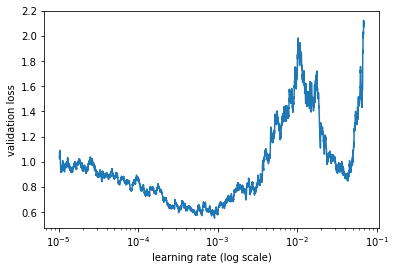

In [20]:
lrf=learn.lr_find()

learn.sched.plot()

In [21]:
lrn=1e-4

In [22]:
lrn

0.0001

In [23]:
learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                      
    0      0.583007   0.524864   0.749535  
    1      0.577433   0.516739   0.751395                      
    2      0.495615   0.516083   0.75155                       
    3      0.543212   0.51892    0.747365                      
    4      0.543594   0.517144   0.747055                      
    5      0.520315   0.51214    0.751085                      
    6      0.580082   0.513559   0.751705                      


[array([0.51356]), 0.7517048977061377]

In [24]:
learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

In [25]:
#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                      
    0      0.502408   0.498319   0.759299  
    1      0.496751   0.484974   0.768909                      
    2      0.480213   0.482051   0.771234                       


In [26]:
#
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.freeze()

sz=400
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)




learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                      
    0      0.413211   0.468362   0.777898  
    1      0.443661   0.464476   0.778053                      
    2      0.440856   0.462871   0.778983                        
    3      0.455453   0.459791   0.784098                        
    4      0.41232    0.457678   0.784563                        
    5      0.484037   0.456631   0.783788                        
    6      0.49531    0.456439   0.785493                       


epoch      trn_loss   val_loss   accuracy                       
    0      0.450131   0.442884   0.787973  
    1      0.462588   0.435404   0.793552                        
    2      0.413236   0.430093   0.794947                        


In [27]:
#
sz=400
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.freeze()

sz=512
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)




learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy                        
    0      0.374046   0.427089   0.799442  
 52%|█████▏    | 3377/6452 [10:10<13:55,  3.68it/s, loss=0.473] 

KeyboardInterrupt: 